In [1]:
from torch_geometric.data import Data
import torch
from torch import load, save, tensor

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import pubchempy as pcp
import sys
import re


# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.dataset import OxidesGraphDataset
from oxides_ml.graph_tools import graph_plotter

graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "surface_order": 3},
                "features": {"adsorbate": False, "radical": False, "valence": False, "cn": True, "magnetization": False},
                "target": "adsorption_energy"}

vasp_directory = "/BACKUP/database/surface_adsorbates"
graph_dataset_dir = "/home/tvanhout/oxides_ML/models/test_graph_datasets"

dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params, initial_state=False, force_reload=False, augment=False)
len(dataset)

/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


530

In [2]:
dataset[0].keys()

['edge_index',
 'state',
 'adsorbate_name',
 'type',
 'idx',
 'ads_energy',
 'x',
 'formula',
 'edge_attr',
 'spin_polarization',
 'material',
 'elem',
 'facet',
 'slab_energy',
 'adsorbate_group',
 'adsorbate_energy',
 'node_feats',
 'energy',
 'target',
 'dissociation',
 'adsorbate_indices',
 'ads_height']

In [17]:
# Keys to exclude from the DataFrame
exclude_keys = {'edge_index', 'edge_attr', 'node_feats', 'x', 'elem', 'idx', 'adsorbate_indices', 'target', 'facet' }  # Add or remove keys as needed

rows = []
for data in dataset:
    row = {}

    for key in data.keys():
        if key in exclude_keys:
            continue
        
        value = data[key]
        
        if isinstance(value, torch.Tensor):
            if value.ndim == 0 or (value.ndim == 1 and len(value) == 1):
                row[key] = value.item()
            elif key in ['adsorbate_indices', 'elem']:
                row[key] = value.tolist()
            else:
                continue
        else:
            row[key] = value

    rows.append(row)

df = pd.DataFrame(rows)

def flag_physisorbed(df, height_threshold=3, energy_threshold=-0.5):
    """
    Add a 'physisorbed' column to the dataframe based on thresholds.

    Args:
        df (pd.DataFrame): DataFrame with 'ads_height' and 'ads_energy' columns.
        height_threshold (float): Min height for physisorption [Å].
        energy_threshold (float): Max adsorption energy for physisorption [eV].

    Returns:
        pd.DataFrame: Modified dataframe with new 'physisorbed' column.
    """
    df['physisorbed'] = (df['ads_height'] >= height_threshold) & (df['ads_energy'] >= energy_threshold)
    return df

df = flag_physisorbed(df)
df.head()

,state,adsorbate_name,type,ads_energy,formula,spin_polarization,material,slab_energy,adsorbate_group,adsorbate_energy,energy,dissociation,ads_height,physisorbed
0,relaxed,Acetaldehyde,adsorbate,-1.285223,C2H4O81Ru40,1,RuO2,-899.063049,alcohols_aldehydes_ketones_ethers,-39.090462,-939.438782,False,1.985657,False
1,relaxed,Acetaldehyde,adsorbate,-1.376368,C2H4O81Ru40,1,RuO2,-899.063049,alcohols_aldehydes_ketones_ethers,-39.090462,-939.529907,False,1.982486,False
2,relaxed,Acetaldehyde,adsorbate,-0.494098,C2H4O81Ru40,1,RuO2,-899.063049,alcohols_aldehydes_ketones_ethers,-39.090462,-938.647644,False,2.003723,False
3,relaxed,Acetaldehyde,adsorbate,-1.370932,C2H4O81Ru40,1,RuO2,-899.063049,alcohols_aldehydes_ketones_ethers,-39.090462,-939.524475,False,1.973013,False
4,relaxed,Ethanol,adsorbate,-1.717263,C2H6O81Ru40,1,RuO2,-899.063049,alcohols_aldehydes_ketones_ethers,-46.925217,-947.705566,False,1.877146,False


/tmp/ipykernel_124103/1072182430.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


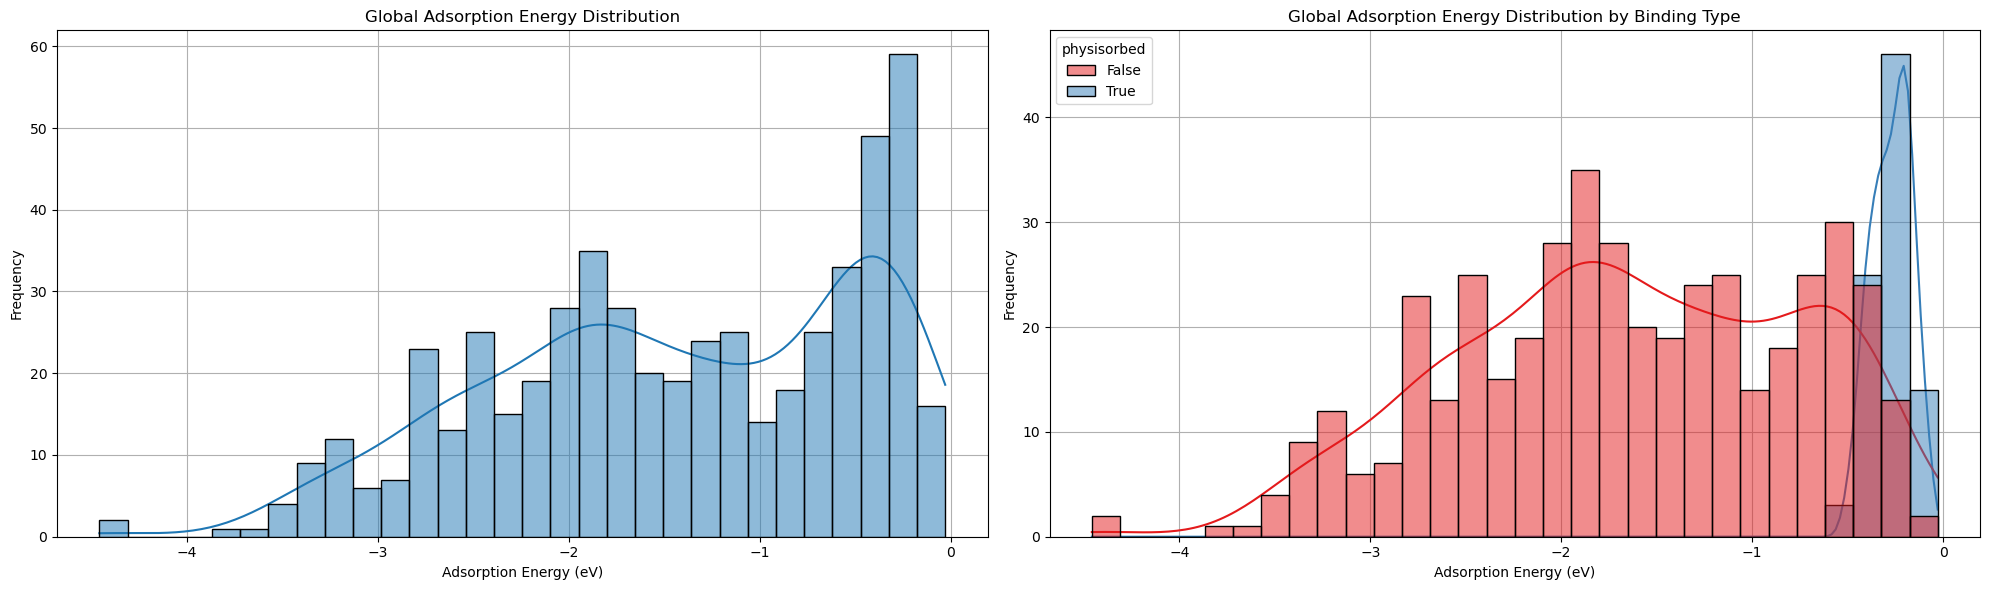

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("Global Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df, x = "ads_energy", hue = 'physisorbed', bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("Global Adsorption Energy Distribution by Binding Type")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_124103/1006952585.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


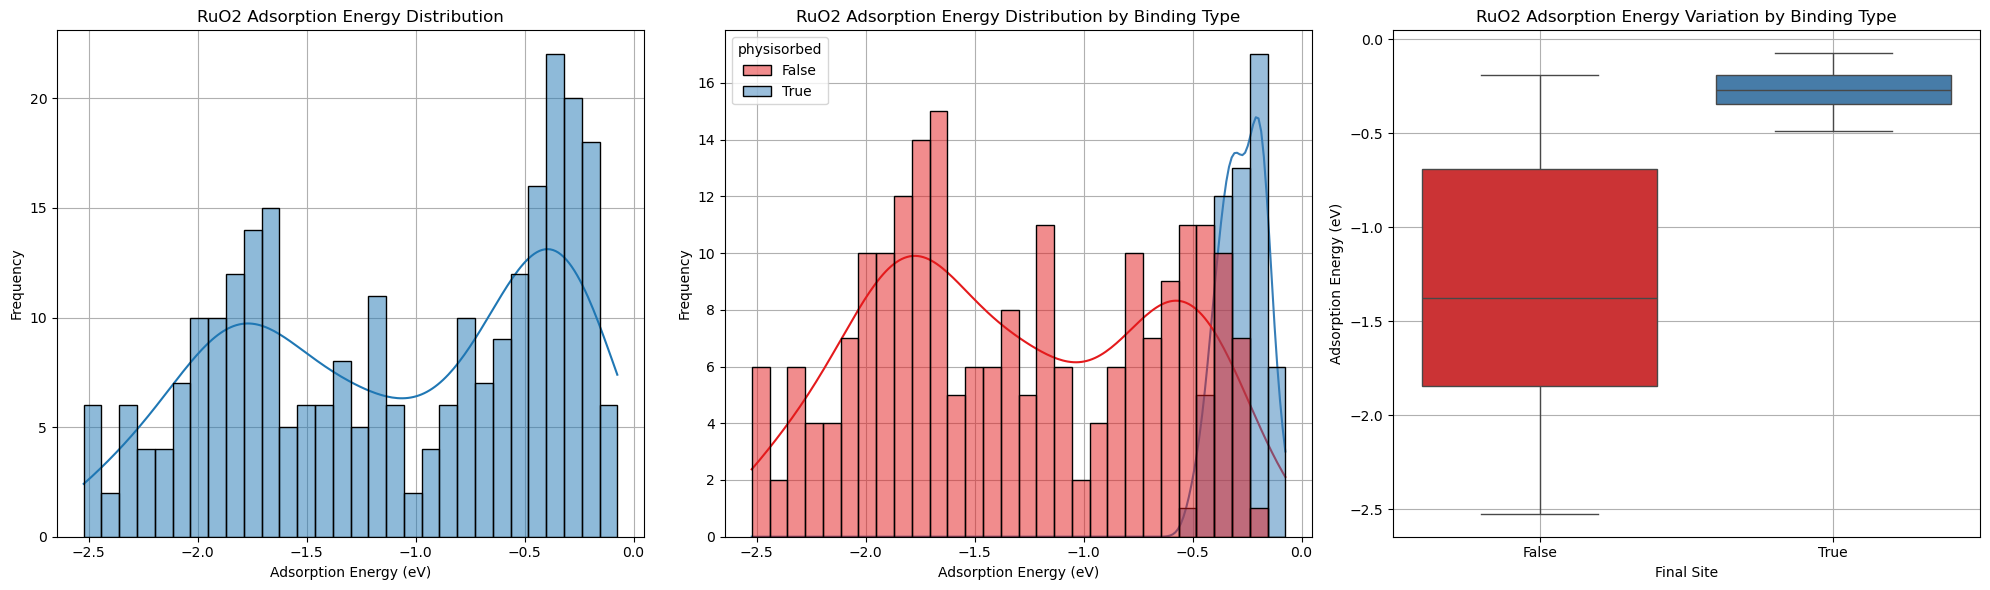

In [5]:
df_RuO2 = df[df['material'] == 'RuO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_RuO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("RuO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_RuO2, x = "ads_energy", hue = 'physisorbed' , bins=30, kde=True, palette="Set1" , edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("RuO2 Adsorption Energy Distribution by Binding Type")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_RuO2, x="physisorbed", y="ads_energy", hue = "physisorbed", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("RuO2 Adsorption Energy Variation by Binding Type")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

/tmp/ipykernel_124103/3574166453.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])


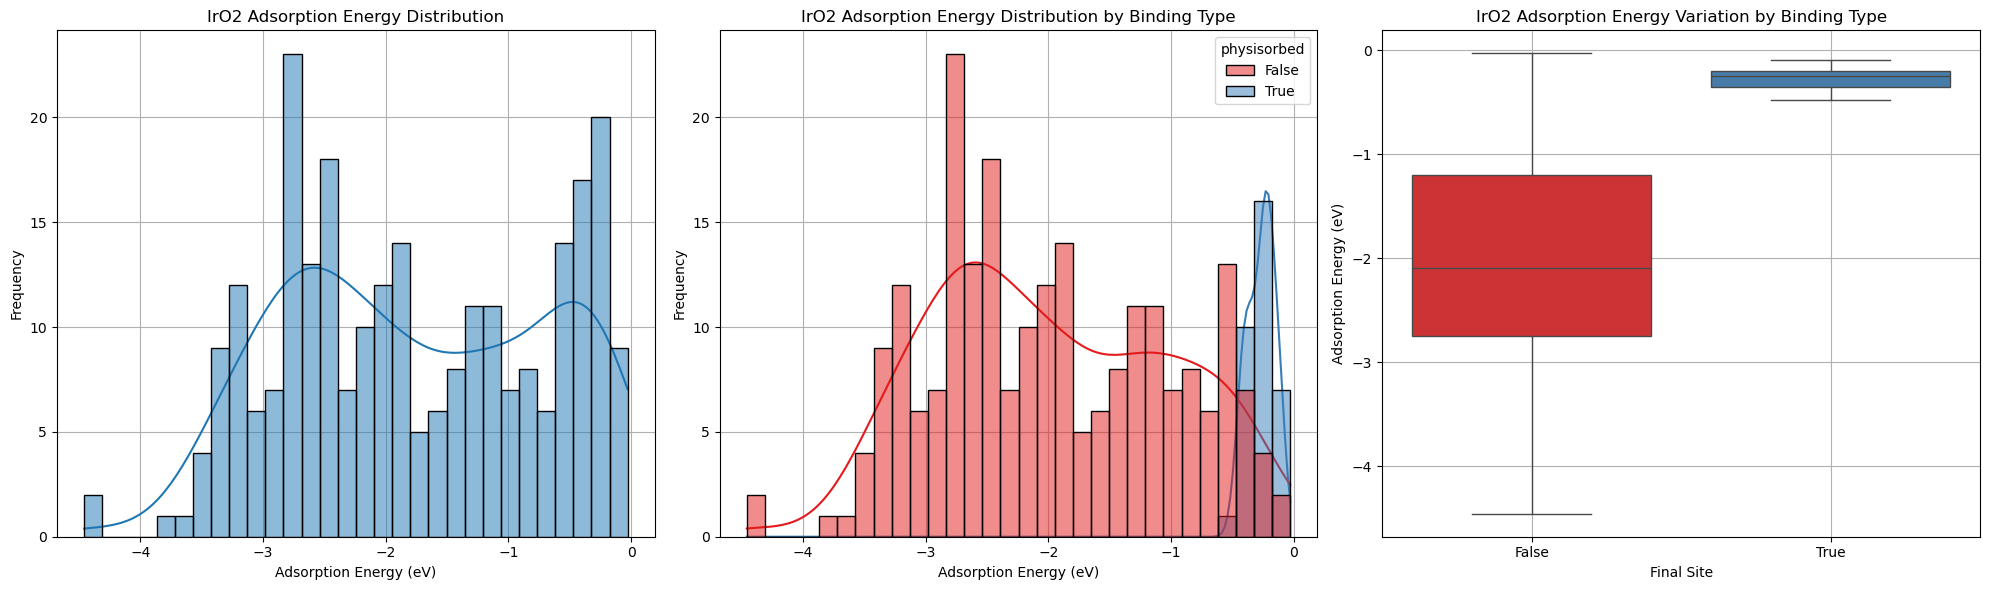

In [6]:
df_IrO2 = df[df['material'] == 'IrO2'].sort_values(by=['adsorbate_group']).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# First plot
sns.histplot(df_IrO2, x = "ads_energy", bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[0])
axes[0].set_title("IrO2 Adsorption Energy Distribution")
axes[0].set_xlabel("Adsorption Energy (eV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Second plot
sns.histplot(df_IrO2, x = "ads_energy", hue = 'physisorbed' , bins=30, kde=True, palette="Set1", edgecolor='black', zorder=10, ax=axes[1])
axes[1].set_title("IrO2 Adsorption Energy Distribution by Binding Type")
axes[1].set_xlabel("Adsorption Energy (eV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Third plot
sns.boxplot(df_IrO2, x="physisorbed", y="ads_energy", hue = "physisorbed", palette="Set1", legend=False, ax=axes[2])
axes[2].set_title("IrO2 Adsorption Energy Variation by Binding Type")
axes[2].set_ylabel("Adsorption Energy (eV)")
axes[2].set_xlabel("Final Site")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()